# Synthetic Image Detection
---

### Mk-0.3  :- Basic CNN (Multi-generator training)
* GPU augmentation with kornia
* Used CNN with...


---

### Data-preprocessing (GenImage -> BigGAN+VQDM dataset) :-

*   Resizing all the images to 224x224 (std. for CNN based models). CNN expects fixed input shape. Avoids inconsistent pixel distributions.
*   Resizing was done locally using python + cmd.


### Requirments

In [ ]:
%pip install torch


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
%pip install -r requirements.txt


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
%pip install kornia


  Using cached kornia-0.8.1-py2.py3-none-any.whl (1.1 MB)
  Using cached kornia_rs-0.1.9-cp311-cp311-win_amd64.whl (2.3 MB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
import os
import time
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.cuda.amp import GradScaler, autocast
from PIL import Image
import kornia.augmentation as K


In [3]:
# ensures Reproducibility (Phirse same results on every run)
import random

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)


### Data loading

In [4]:
# directories
train_dir = rf"C:\Users\sarth\Dataset\train"
test_dir = rf"C:\Users\sarth\Dataset\val"

# Check contents of the folders
print("Train Directory:", os.listdir(train_dir))
print("Test Directory:", os.listdir(test_dir))


Train Directory: ['ai', 'nature']
Test Directory: ['ai', 'nature']


In [5]:
# Basic transform to load images as tensors on CPU first
train_base_transform = transforms.Compose([
    transforms.ToTensor(),  # just convert to tensor
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224))
])

# Datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_base_transform)
val_dataset = datasets.ImageFolder(root=test_dir, transform=val_transform)

# Dataloaders (CPU only does basic loading)
batch_size = 32
num_workers = 2

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=False,
    persistent_workers=True,
    prefetch_factor=1
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=False,
    persistent_workers=True,
    prefetch_factor=1
)

# Define GPU augmentations using Kornia
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

gpu_train_augment = K.AugmentationSequential(
    K.RandomCrop((224, 224), padding=8),
    K.RandomHorizontalFlip(p=0.5),
    K.RandomRotation(degrees=15.0),
    K.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15),
    K.RandomGaussianBlur((3, 3), (0.1, 1.0)),
    data_keys=["input"]
).to(device)

# Normalization function (after GPU augmentation)
mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(1, 3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225], device=device).view(1, 3, 1, 1)

def normalize_batch(batch):
    return (batch - mean) / std

print(f"Train samples: {len(train_dataset)} | Val samples: {len(val_dataset)}")
print(f"Classes: {train_dataset.classes}")


Train samples: 647996 | Val samples: 24000
Classes: ['ai', 'nature']


### Checking loaders & resource (GPU)

In [5]:
# Check for corrupted images in dataset folders
FOLDERS = [
    rf"C:\Users\sarth\Dataset\train\ai",
    rf"C:\Users\sarth\Dataset\train\nature",
    rf"C:\Users\sarth\Dataset\val\ai",
    rf"C:\Users\sarth\Dataset\val\nature"
]

bad_files = []

for folder in FOLDERS:
    print(f"Checking folder: {folder}")
    files = [
        f for f in os.listdir(folder)
        if f.lower().endswith((".jpg", ".jpeg", ".png", ".bmp"))
    ]
    for f in tqdm(files, desc=os.path.basename(folder)):
        path = os.path.join(folder, f)
        try:
            with Image.open(path) as img:
                img.verify()  # Checks for corruption
        except Exception as e:
            bad_files.append((path, str(e)))

print(f"\nScan complete. {len(bad_files)} bad images found.")
if bad_files:
    print("Examples:")
    for bf in bad_files[:10]:
        print("  ", bf[0])


Checking folder: C:\Users\sarth\Dataset\train\ai


ai: 100%|██████████| 323996/323996 [01:52<00:00, 2891.15it/s]


Checking folder: C:\Users\sarth\Dataset\train\nature


nature: 100%|██████████| 324000/324000 [01:48<00:00, 2973.53it/s]


Checking folder: C:\Users\sarth\Dataset\val\ai


ai: 100%|██████████| 12000/12000 [00:04<00:00, 2800.62it/s]


Checking folder: C:\Users\sarth\Dataset\val\nature


nature: 100%|██████████| 12000/12000 [00:04<00:00, 2666.42it/s]


Scan complete. 0 bad images found.


In [6]:
import torch
print(torch.cuda.is_available())
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))


False


In [7]:
import torch
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


CUDA available: False


### Defining basic CNN

In [10]:
# SImpleCNN upgraded with explicit Grad-CAM layer and regularization
class SimpleCNN_v2(nn.Module):
    def __init__(self):
        super(SimpleCNN_v2, self).__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32), # stabilizes gradients
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Explicit Grad-CAM layer
        self.last_conv = nn.Conv2d(64, 256, 3, padding=1)
        self.bn_last   = nn.BatchNorm2d(256)
        self.relu_last = nn.ReLU()
        self.pool_last = nn.MaxPool2d(2)

        # Global average pooling and classifier
        self.gap = nn.AdaptiveAvgPool2d(1) # Reduces Overfitting and enables Grad-CAM (Regularization)

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.ReLU(),           # Adds non-linearity before FC layers
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.4),     # Regularization (Reduces overfitting)
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.last_conv(x)
        x = self.bn_last(x)
        x = self.relu_last(x)
        x = self.pool_last(x)
        x = self.gap(x)
        x = self.fc_layers(x)
        return x

# Instantiate model
model = SimpleCNN_v2()


### Model Training

In [8]:
# Setup for training with checkpointing
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN_v2().to(device)

criterion = nn.BCEWithLogitsLoss()      # More stable than BCELoss with raw outputs (stable binary classification)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)  # L2 Regularization

# Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.7) # reduces LR only if validation accuracy plateaus
scaler = torch.amp.GradScaler("cuda") # for safe scaling during backprop

# Maintaing history for analysis
history = {"train_loss": [], "val_acc": [], "val_loss": [], "lr": []}

# Directory for saving checkpoints
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, "last_checkpoint.pth")

start_epoch = 0
best_acc = 0.0

# Load checkpoint if resuming
if os.path.exists(checkpoint_path):
    print("Resuming from last checkpoint...")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["optimizer_state"])
    scheduler.load_state_dict(checkpoint["scheduler_state"])
    scaler.load_state_dict(checkpoint["scaler_state"])
    start_epoch = checkpoint["epoch"] + 1
    best_acc = checkpoint.get("best_acc", 0.0)
    print(f"Resumed from epoch {start_epoch} with best accuracy {best_acc:.4f}")

patience = 3  # for early stopping: stop after 3 epochs with no improvement
patience_counter = 0
epochs = 10

# Training loop
for epoch in range(start_epoch, epochs):
    model.train()
    running_loss = 0.0
    print(f"Epoch {epoch+1}/{epochs}: ")

    with tqdm(train_loader, desc="Training", unit="batch") as tepoch:
        for images, labels in tepoch:
            images, labels = images.to(device), labels.float().unsqueeze(1).to(device)

            images = gpu_train_augment(images)
            images = normalize_batch(images)

            optimizer.zero_grad()               # clear gradients for next batch
            with torch.amp.autocast("cuda"):    # Mixed precision forward
                outputs = model(images)
                loss = criterion(outputs, labels)

            # backward pass
            scaler.scale(loss).backward()
            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)    # Gradients stable is not needed as we stabalised it with BatchNorm and Mixed Precision
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.detach().item()
            tepoch.set_postfix(loss=loss.item())


    # Validation
    model.eval()
    correct, total, val_loss = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            images = normalize_batch(images)

            outputs = model(images)
            loss_val = criterion(outputs, labels.unsqueeze(1).float())
            val_loss += loss_val.item()
            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct += (preds == labels.unsqueeze(1)).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    val_loss /= len(val_loader)
    avg_loss = running_loss / len(train_loader)

    scheduler.step(val_loss) # step based on validation loss

    if (epoch + 1) % 2 == 0 and device.type == "cuda":
        print("Clearing unused CUDA memory to avoid fragmentation...")
        torch.cuda.empty_cache()        # clear unused memory every 2 epochs to avoid fragmentation

    current_lr = optimizer.param_groups[0]['lr'] # get current learning rate

    print(f"Epoch {epoch+1} | Train Loss: {avg_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | LR: {current_lr:.6f}")

    history["train_loss"].append(avg_loss)
    history["val_acc"].append(val_acc)
    history["val_loss"].append(val_loss)
    history["lr"].append(current_lr)


    # Proactive early stopping based on validation accuracy
    if val_acc > best_acc:
        best_acc = val_acc
        patience_counter = 0  # reset counter
        best_checkpoint = {
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "scheduler_state": scheduler.state_dict(),
            "scaler_state": scaler.state_dict(),
            "best_acc": best_acc
        }
        torch.save(best_checkpoint, os.path.join(checkpoint_dir, "best_checkpoint.pth"))
        print(f"Best model updated! New Val Acc: {best_acc:.4f}")
    else:
        patience_counter += 1
        print(f"No improvement for {patience_counter}/{patience} epochs.")

    # Initiate early stop
    if patience_counter >= patience:
        print("\nEarly stopping initiated: no improvement for 3 epochs.")
        torch.save(best_checkpoint, os.path.join(checkpoint_dir, "final_best_model.pth"))
        print("Final best model saved before stopping.")
        break


    # Save checkpoints
    checkpoint = {
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "scheduler_state": scheduler.state_dict(),
        "scaler_state": scaler.state_dict(),
        "best_acc": best_acc
    }
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved at epoch {epoch+1}")
    print("Initiating next epoch in 20 seconds...")
    time.sleep(20)  # CPU cooldown before next epoch



print("\nTraining complete 🔥")


C:\Users\sarth\AppData\Local\Temp\ipykernel_25156\2739816746.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=devic

Resuming from last checkpoint...
Resumed from epoch 1 with best accuracy 0.8860
Epoch 2/10: 


Training:  52%|█████▏    | 10625/20250 [48:17<43:44,  3.67batch/s, loss=0.457]  


KeyboardInterrupt: 

In [10]:
torch.cuda.empty_cache() # Clears VRAM memory cache


### Analysis

In [ ]:
# load best model for evaluation
checkpoint_dir = "checkpoints"
checkpoint = torch.load(os.path.join(checkpoint_dir, "best_checkpoint.pth"), map_location=device)
model.load_state_dict(checkpoint["model_state"])


<All keys matched successfully>

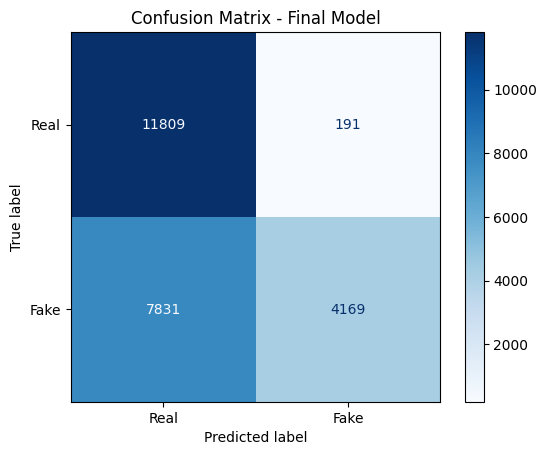

Final Validation Accuracy: 0.5000


In [12]:
all_preds, all_labels = [], []

model.eval()  # Make sure model is in evaluation mode
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        preds = (outputs > 0.5).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=["Real", "Fake"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Final Model")
plt.show()

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Final validation accuracy
val_acc = (all_preds == all_labels).mean()
print(f"Final Validation Accuracy: {val_acc:.4f}")


In [ ]:
# r2 score
r2 = roc_auc_score(all_labels, all_preds)
print(f"ROC AUC Score: {r2:.4f}")

# classification report
report = classification_report(all_labels, all_preds, target_names=["Real", "Fake"])
print("Classification Report:\n", report)


ROC AUC Score: 0.6658
Classification Report:
               precision    recall  f1-score   support

        Real       0.60      0.98      0.75     12000
        Fake       0.96      0.35      0.51     12000

    accuracy                           0.67     24000
   macro avg       0.78      0.67      0.63     24000
weighted avg       0.78      0.67      0.63     24000



In [17]:
# Detailed evaluation with probabilities

model.eval()
all_probs, all_preds, all_labels = [], [], []
val_loss = 0.0
criterion = nn.BCEWithLogitsLoss()

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item() * images.size(0)
        probs = torch.sigmoid(outputs).cpu().numpy().ravel()
        preds = (probs > 0.5).astype(int)
        all_probs.extend(probs.tolist())
        all_preds.extend(preds.tolist())
        all_labels.extend(labels.cpu().numpy().ravel().astype(int).tolist())

val_loss = val_loss / len(val_dataset)
print(f"Val loss: {val_loss:.4f}, Val acc: {np.mean(np.array(all_preds)==np.array(all_labels)):.4f}")

# Classification report + AUC
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))
try:
    auc = roc_auc_score(all_labels, all_probs)
    print("ROC AUC:", auc)
except Exception as e:
    print("ROC AUC could not be computed:", e)


Val loss: 0.5111, Val acc: 0.7267
              precision    recall  f1-score   support

          ai       0.65      0.97      0.78     12000
      nature       0.94      0.49      0.64     12000

    accuracy                           0.73     24000
   macro avg       0.79      0.73      0.71     24000
weighted avg       0.79      0.73      0.71     24000

ROC AUC: 0.9202571701388889


### Testing on VQDM val dataset

In [ ]:
VQDM_test_dir = rf'D:\sarthak\RCOEM\3rd\Projects\ML\Synthetic Media detection\Datasets\VQDM\imagenet_ai_0419_vqdm\imagenet_ai_0419_vqdm\val'
VQDM_val_dataset = datasets.ImageFolder(root=VQDM_test_dir, transform=val_transform)
VQDM_val_loader = DataLoader(VQDM_val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)


In [ ]:
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in VQDM_val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct += (preds == labels.unsqueeze(1)).sum().item()
        total += labels.size(0)

val_acc = correct / total
scheduler.step(val_acc)


In [ ]:
print(val_acc)


In [ ]:
torch.cuda.empty_cache()


In [ ]:
all_preds_VQDM, all_labels_VQDM = [], []

model.eval()  # Make sure model is in evaluation mode
with torch.no_grad():
    for images, labels in VQDM_val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        preds = (outputs > 0.5).float()
        all_preds_VQDM.extend(preds.cpu().numpy())
        all_labels_VQDM.extend(labels.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(all_labels_VQDM, all_preds_VQDM)
disp = ConfusionMatrixDisplay(cm, display_labels=["Real", "Fake"])
disp.plot(cmap=plt.cm.Reds)
plt.title("Confusion Matrix - VQDM val dataset")
plt.show()

all_preds_VQDM = np.array(all_preds_VQDM)
all_labels_VQDM = np.array(all_labels_VQDM)

# Final validation accuracy
val_acc = (all_preds_VQDM == all_labels_VQDM).mean()
print(f"Final VQDM Validation Accuracy: {val_acc:.4f}")


### Evaluation

In [ ]:
def evaluate_images(model, image_paths, transform, device):
    """
    Display predictions for multiple input images with confidence scores.

    Args:
        model: Trained PyTorch model.
        image_paths: List of image file paths.
        transform: Transform pipeline (e.g., val_transform).
        device: 'cuda' or 'cpu'.
    """

    model.eval()
    plt.figure(figsize=(14, 6))

    for i, img_path in enumerate(image_paths):
        try:
            # Load and preprocess image
            img = Image.open(img_path).convert("RGB")
            img_t = transform(img).unsqueeze(0).to(device)

            # Predict
            with torch.no_grad():
                output = model(img_t)
                prob = torch.sigmoid(output).item()

            # Classification decision
            label = "Fake (AI-generated)" if prob > 0.5 else "Real (original)"
            conf = prob if prob > 0.5 else 1 - prob

            # Plotting
            plt.subplot(2, (len(image_paths) + 1) // 2, i + 1)
            plt.imshow(np.array(img))
            plt.axis("off")
            plt.title(f"{label}\nConf: {conf:.3f}", fontsize=10)

        except Exception as e:
            print(f"Error processing {img_path}: {e}")

    plt.tight_layout()
    plt.show()



In [ ]:
image_paths = []

evaluate_images(model, image_paths, val_transform, device)
